# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [13]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

external_data_path = "../data/external/"
image_path = "images/"

In [2]:
# Choose small or large dataset: False=small, True=large
# large_dataset = True
large_dataset = False
train_ratio = 0.8

if(large_dataset):
    folder_name = external_data_path + "ml-32m"
else:
    folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []


test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.20359134674072266 seconds
Train Count: 80756
Test Count: 20080


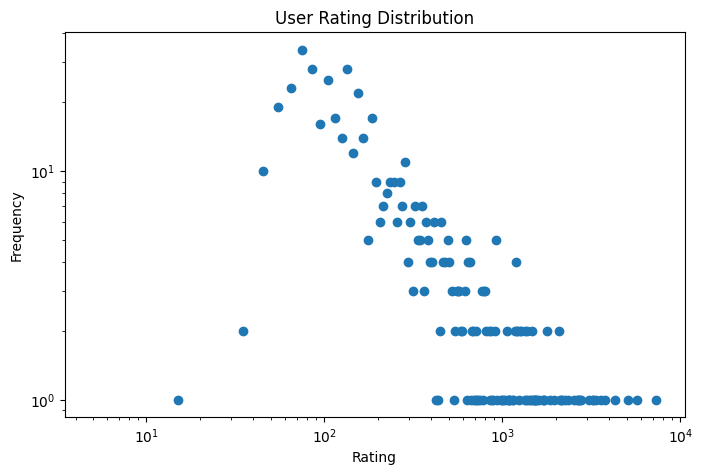

In [3]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

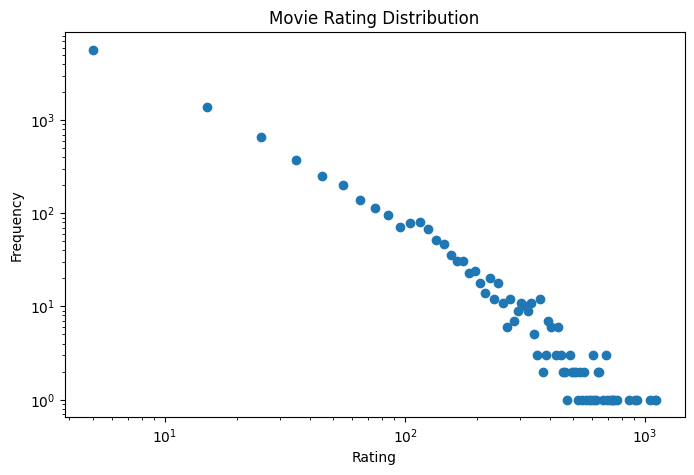

In [4]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

In [5]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 6239.7721, Train RMSE: 0.8055, Test RMSE: 0.8795
Epoch 2/100, Loss: 6047.0266, Train RMSE: 0.7917, Test RMSE: 0.8677
Epoch 3/100, Loss: 6019.3909, Train RMSE: 0.7906, Test RMSE: 0.8671
Epoch 4/100, Loss: 6002.8607, Train RMSE: 0.7904, Test RMSE: 0.8670
Epoch 5/100, Loss: 5989.4026, Train RMSE: 0.7903, Test RMSE: 0.8669
Epoch 6/100, Loss: 5978.1276, Train RMSE: 0.7903, Test RMSE: 0.8669
Epoch 7/100, Loss: 5968.6530, Train RMSE: 0.7903, Test RMSE: 0.8670
Epoch 8/100, Loss: 5960.6878, Train RMSE: 0.7903, Test RMSE: 0.8671
Epoch 9/100, Loss: 5953.9911, Train RMSE: 0.7903, Test RMSE: 0.8672
Epoch 10/100, Loss: 5948.3607, Train RMSE: 0.7904, Test RMSE: 0.8673
Epoch 11/100, Loss: 5943.6269, Train RMSE: 0.7904, Test RMSE: 0.8674
Epoch 12/100, Loss: 5939.6468, Train RMSE: 0.7905, Test RMSE: 0.8675
Epoch 13/100, Loss: 5936.3005, Train RMSE: 0.7905, Test RMSE: 0.8677
Epoch 14/100, Loss: 5933.4870, Train RMSE: 0.7906, Test RMSE: 0.8678
Epoch 15/100, Loss: 5931.1215, Train RMSE: 

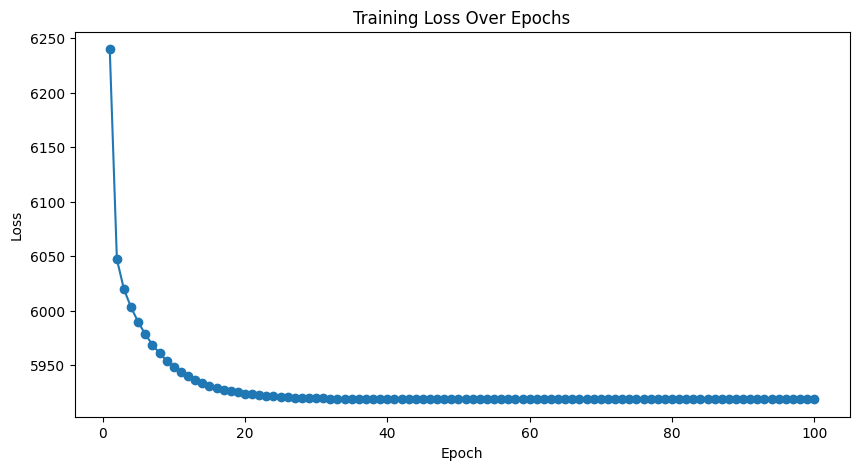

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

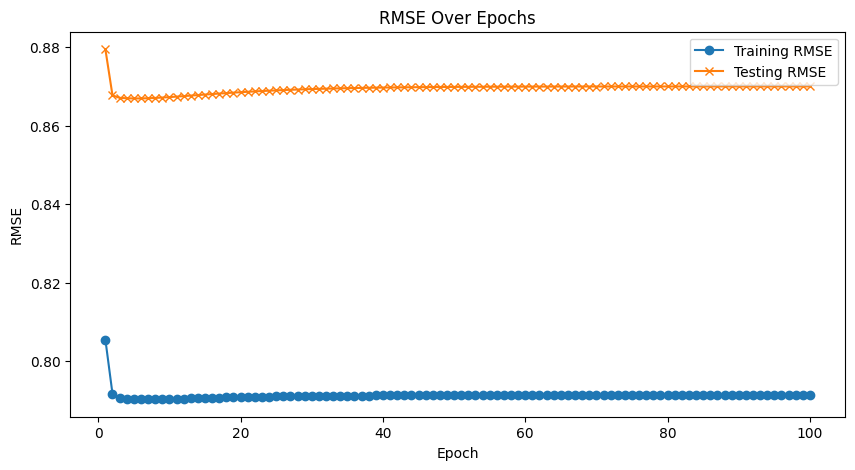

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

In [ ]:
def training_old(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[m]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[m] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [9]:
def training_optimised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    tau_identity = tau * np.eye(embeddings_dim)

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            counter = 0
            ratings = np.zeros(len(user_ratings_train[u]))
            pred = np.zeros(len(user_ratings_train[u]))
            for movie_idx, rating in user_ratings_train[u]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            user_biases[u] = bias / ((lam * counter) + gamma)
            
            user_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            user_term = np.zeros(embeddings_dim)
            for movie_idx, rating in user_ratings_train[u]:
                item_vec = item_embeddings[movie_idx]
                user_inverse_term += np.outer(item_vec, item_vec)
                user_term += item_vec * (rating - user_biases[u] - item_biases[movie_idx])
            user_inverse_term = (lam * user_inverse_term) + tau_identity
            user_embeddings[u] = np.linalg.solve(user_inverse_term, lam * user_term)

        for m in range(len(movie_ratings_train)):
            counter = 0
            ratings = np.zeros(len(movie_ratings_train[m]))
            pred = np.zeros(len(movie_ratings_train[m]))
            for user_idx, rating in movie_ratings_train[m]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            item_biases[m] = bias / ((lam * counter) + gamma)

            item_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            item_term = np.zeros(embeddings_dim)
            for user_idx, rating in movie_ratings_train[m]:
                user_vec = user_embeddings[user_idx]
                item_inverse_term += np.outer(user_vec, user_vec)
                item_term += user_vec * (rating - user_biases[user_idx] - item_biases[m])
            item_inverse_term = (lam * item_inverse_term) +  tau_identity
            item = np.linalg.solve(item_inverse_term, lam * item_term)
            item_embeddings[m] = item

        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings**2) + np.sum(item_embeddings**2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [10]:
# Hyperparameters
lam = 1
gamma = 1
tau = 10
num_epochs = 20
embeddings_dim = 10
const = 1

scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 62379.6127, Train RMSE: 0.7893, Test RMSE: 0.8788
Epoch 2/20, Loss: 57066.8166, Train RMSE: 0.7191, Test RMSE: 0.8631
Epoch 3/20, Loss: 54408.1260, Train RMSE: 0.6677, Test RMSE: 0.8639
Epoch 4/20, Loss: 53585.5085, Train RMSE: 0.6516, Test RMSE: 0.8645
Epoch 5/20, Loss: 53171.3566, Train RMSE: 0.6449, Test RMSE: 0.8643
Epoch 6/20, Loss: 52906.3163, Train RMSE: 0.6413, Test RMSE: 0.8638
Epoch 7/20, Loss: 52714.7621, Train RMSE: 0.6392, Test RMSE: 0.8633
Epoch 8/20, Loss: 52567.4058, Train RMSE: 0.6377, Test RMSE: 0.8628
Epoch 9/20, Loss: 52450.2735, Train RMSE: 0.6366, Test RMSE: 0.8624
Epoch 10/20, Loss: 52355.3143, Train RMSE: 0.6358, Test RMSE: 0.8620
Epoch 11/20, Loss: 52277.2350, Train RMSE: 0.6352, Test RMSE: 0.8617
Epoch 12/20, Loss: 52212.3189, Train RMSE: 0.6347, Test RMSE: 0.8615
Epoch 13/20, Loss: 52157.8716, Train RMSE: 0.6343, Test RMSE: 0.8613
Epoch 14/20, Loss: 52111.8972, Train RMSE: 0.6340, Test RMSE: 0.8612
Epoch 15/20, Loss: 52072.8871, Train RMSE: 

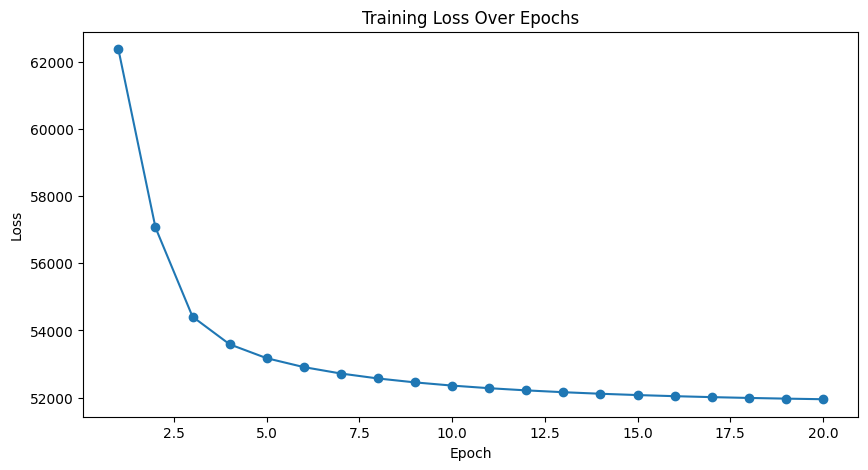

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'embeddings_trianing_loss.svg')
plt.show()

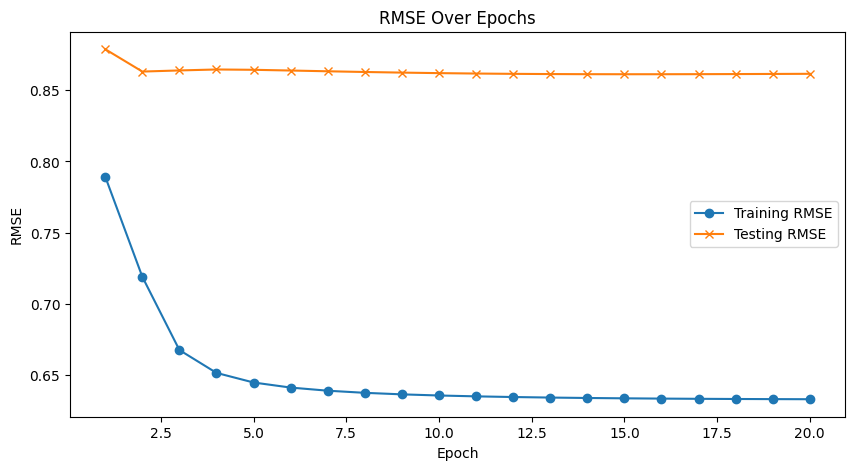

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'embeddings_rmse.svg')
plt.show()

In [14]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-5, 1.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True)
    tau = trial.suggest_float('tau', 1e-5, 1.0, log=True)
    embeddings_dim = trial.suggest_int('embeddings_dim', 10, 100)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20  # Keep it small for tuning, increase later
    
    training_loss, training_RMSE, testing_RMSE, _, _ = training_optimised(
        num_epochs=num_epochs,
        lam=lam,
        gamma=gamma,
        tau=tau,
        embeddings_dim=embeddings_dim,
        scale=scale
    )

    # Optimize based on final test RMSE (last epoch)
    return testing_RMSE[-1]  # Lower RMSE is better

In [ ]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best test RMSE:", study.best_value)



[I 2025-07-17 10:47:36,243] A new study created in memory with name: no-name-8dc186bb-e57b-40ca-8703-efee0d580c10


Epoch 1/20, Loss: 8.7208, Train RMSE: 0.9455, Test RMSE: 1.0212
Epoch 2/20, Loss: 5.8482, Train RMSE: 0.7894, Test RMSE: 0.8696
Epoch 3/20, Loss: 5.8098, Train RMSE: 0.7871, Test RMSE: 0.8684
Epoch 4/20, Loss: 5.7979, Train RMSE: 0.7868, Test RMSE: 0.8683
Epoch 5/20, Loss: 5.7886, Train RMSE: 0.7867, Test RMSE: 0.8682
Epoch 6/20, Loss: 5.7805, Train RMSE: 0.7866, Test RMSE: 0.8682
Epoch 7/20, Loss: 5.7734, Train RMSE: 0.7866, Test RMSE: 0.8682
Epoch 8/20, Loss: 5.7672, Train RMSE: 0.7866, Test RMSE: 0.8682
Epoch 9/20, Loss: 5.7618, Train RMSE: 0.7866, Test RMSE: 0.8682
Epoch 10/20, Loss: 5.7571, Train RMSE: 0.7866, Test RMSE: 0.8683
Epoch 11/20, Loss: 5.7529, Train RMSE: 0.7866, Test RMSE: 0.8683
Epoch 12/20, Loss: 5.7493, Train RMSE: 0.7866, Test RMSE: 0.8684
Epoch 13/20, Loss: 5.7461, Train RMSE: 0.7867, Test RMSE: 0.8685
Epoch 14/20, Loss: 5.7434, Train RMSE: 0.7867, Test RMSE: 0.8685
Epoch 15/20, Loss: 5.7409, Train RMSE: 0.7867, Test RMSE: 0.8686
Epoch 16/20, Loss: 5.7388, Train R

[I 2025-07-17 10:48:10,697] Trial 0 finished with value: 0.8690544134015082 and parameters: {'lam': 0.00010095388586375818, 'gamma': 7.272622173852929e-05, 'tau': 0.007333906254505829, 'embeddings_dim': 42, 'scale': 0.9580470445856443}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 5.7326, Train RMSE: 0.7868, Test RMSE: 0.8691
Epoch 1/20, Loss: 388.0087, Train RMSE: 0.1635, Test RMSE: 4.8519
Epoch 2/20, Loss: 170.0565, Train RMSE: 0.1067, Test RMSE: 3.9182
Epoch 3/20, Loss: 101.3111, Train RMSE: 0.0810, Test RMSE: 3.6939
Epoch 4/20, Loss: 68.8412, Train RMSE: 0.0654, Test RMSE: 3.6020
Epoch 5/20, Loss: 50.4751, Train RMSE: 0.0547, Test RMSE: 3.5398
Epoch 6/20, Loss: 38.9761, Train RMSE: 0.0467, Test RMSE: 3.5143
Epoch 7/20, Loss: 31.3412, Train RMSE: 0.0406, Test RMSE: 3.5077
Epoch 8/20, Loss: 26.0724, Train RMSE: 0.0358, Test RMSE: 3.4845
Epoch 9/20, Loss: 22.2955, Train RMSE: 0.0319, Test RMSE: 3.4540
Epoch 10/20, Loss: 19.4939, Train RMSE: 0.0287, Test RMSE: 3.4202
Epoch 11/20, Loss: 17.3597, Train RMSE: 0.0260, Test RMSE: 3.3858
Epoch 12/20, Loss: 15.6970, Train RMSE: 0.0236, Test RMSE: 3.3582
Epoch 13/20, Loss: 14.3792, Train RMSE: 0.0216, Test RMSE: 3.3324
Epoch 14/20, Loss: 13.3194, Train RMSE: 0.0199, Test RMSE: 3.3154
Epoch 15/20, Loss

[I 2025-07-17 10:49:07,437] Trial 1 finished with value: 3.2431972947584438 and parameters: {'lam': 0.1753607352314786, 'gamma': 0.0003223566228544517, 'tau': 1.0339018450815517e-05, 'embeddings_dim': 82, 'scale': 0.8933394439757182}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 9.8791, Train RMSE: 0.0128, Test RMSE: 3.2432
Epoch 1/20, Loss: 10.2323, Train RMSE: 0.1317, Test RMSE: 1.3472
Epoch 2/20, Loss: 7.1964, Train RMSE: 0.0618, Test RMSE: 1.1878
Epoch 3/20, Loss: 6.2693, Train RMSE: 0.0358, Test RMSE: 1.1314
Epoch 4/20, Loss: 5.7714, Train RMSE: 0.0232, Test RMSE: 1.1018
Epoch 5/20, Loss: 5.4376, Train RMSE: 0.0163, Test RMSE: 1.0829
Epoch 6/20, Loss: 5.1862, Train RMSE: 0.0124, Test RMSE: 1.0697
Epoch 7/20, Loss: 4.9835, Train RMSE: 0.0101, Test RMSE: 1.0600
Epoch 8/20, Loss: 4.8128, Train RMSE: 0.0088, Test RMSE: 1.0528
Epoch 9/20, Loss: 4.6648, Train RMSE: 0.0080, Test RMSE: 1.0475
Epoch 10/20, Loss: 4.5339, Train RMSE: 0.0076, Test RMSE: 1.0438
Epoch 11/20, Loss: 4.4164, Train RMSE: 0.0072, Test RMSE: 1.0413
Epoch 12/20, Loss: 4.3098, Train RMSE: 0.0070, Test RMSE: 1.0397
Epoch 13/20, Loss: 4.2121, Train RMSE: 0.0069, Test RMSE: 1.0389
Epoch 14/20, Loss: 4.1219, Train RMSE: 0.0067, Test RMSE: 1.0388
Epoch 15/20, Loss: 4.0383, Train 

[I 2025-07-17 10:50:07,229] Trial 2 finished with value: 1.045494293007708 and parameters: {'lam': 0.0007675672095556048, 'gamma': 0.0005394516010415575, 'tau': 7.281480964990747e-05, 'embeddings_dim': 86, 'scale': 0.05348622726843088}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 3.6928, Train RMSE: 0.0063, Test RMSE: 1.0455
Epoch 1/20, Loss: 182.3666, Train RMSE: 0.4666, Test RMSE: 1.1318
Epoch 2/20, Loss: 86.9160, Train RMSE: 0.2032, Test RMSE: 1.0748
Epoch 3/20, Loss: 68.1258, Train RMSE: 0.1441, Test RMSE: 1.0546
Epoch 4/20, Loss: 58.6260, Train RMSE: 0.1133, Test RMSE: 1.0471
Epoch 5/20, Loss: 52.7431, Train RMSE: 0.0940, Test RMSE: 1.0437
Epoch 6/20, Loss: 48.6979, Train RMSE: 0.0807, Test RMSE: 1.0418
Epoch 7/20, Loss: 45.7250, Train RMSE: 0.0711, Test RMSE: 1.0406
Epoch 8/20, Loss: 43.4370, Train RMSE: 0.0638, Test RMSE: 1.0398
Epoch 9/20, Loss: 41.6164, Train RMSE: 0.0582, Test RMSE: 1.0393
Epoch 10/20, Loss: 40.1309, Train RMSE: 0.0536, Test RMSE: 1.0389
Epoch 11/20, Loss: 38.8948, Train RMSE: 0.0499, Test RMSE: 1.0386
Epoch 12/20, Loss: 37.8498, Train RMSE: 0.0469, Test RMSE: 1.0384
Epoch 13/20, Loss: 36.9546, Train RMSE: 0.0444, Test RMSE: 1.0383
Epoch 14/20, Loss: 36.1790, Train RMSE: 0.0422, Test RMSE: 1.0382
Epoch 15/20, Loss: 

[I 2025-07-17 10:50:50,926] Trial 3 finished with value: 1.038711736331995 and parameters: {'lam': 0.005694294477749034, 'gamma': 0.00267217751516015, 'tau': 0.0016372372442579487, 'embeddings_dim': 61, 'scale': 0.8350978213844}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 33.0732, Train RMSE: 0.0343, Test RMSE: 1.0387
Epoch 1/20, Loss: 391.1287, Train RMSE: 0.8544, Test RMSE: 0.9153
Epoch 2/20, Loss: 355.9197, Train RMSE: 0.8506, Test RMSE: 0.9111
Epoch 3/20, Loss: 345.4824, Train RMSE: 0.8428, Test RMSE: 0.9142
Epoch 4/20, Loss: 341.4779, Train RMSE: 0.8394, Test RMSE: 0.9182
Epoch 5/20, Loss: 339.8270, Train RMSE: 0.8386, Test RMSE: 0.9214
Epoch 6/20, Loss: 339.1187, Train RMSE: 0.8389, Test RMSE: 0.9238
Epoch 7/20, Loss: 338.8060, Train RMSE: 0.8393, Test RMSE: 0.9255
Epoch 8/20, Loss: 338.6646, Train RMSE: 0.8398, Test RMSE: 0.9267
Epoch 9/20, Loss: 338.5992, Train RMSE: 0.8401, Test RMSE: 0.9275
Epoch 10/20, Loss: 338.5679, Train RMSE: 0.8404, Test RMSE: 0.9281
Epoch 11/20, Loss: 338.5524, Train RMSE: 0.8406, Test RMSE: 0.9284
Epoch 12/20, Loss: 338.5442, Train RMSE: 0.8407, Test RMSE: 0.9287
Epoch 13/20, Loss: 338.5396, Train RMSE: 0.8408, Test RMSE: 0.9288
Epoch 14/20, Loss: 338.5368, Train RMSE: 0.8409, Test RMSE: 0.9289
Epoch

[I 2025-07-17 10:51:40,303] Trial 4 finished with value: 0.9290867947866482 and parameters: {'lam': 0.00293859061127446, 'gamma': 0.03191815266524708, 'tau': 0.06377576871401862, 'embeddings_dim': 71, 'scale': 0.342622582536854}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 338.5309, Train RMSE: 0.8410, Test RMSE: 0.9291
Epoch 1/20, Loss: 7690.6807, Train RMSE: 0.3098, Test RMSE: 1.1496
Epoch 2/20, Loss: 4847.9375, Train RMSE: 0.2202, Test RMSE: 1.1189
Epoch 3/20, Loss: 3868.9857, Train RMSE: 0.1795, Test RMSE: 1.1070
Epoch 4/20, Loss: 3385.8944, Train RMSE: 0.1563, Test RMSE: 1.1014
Epoch 5/20, Loss: 3098.7920, Train RMSE: 0.1410, Test RMSE: 1.0994
Epoch 6/20, Loss: 2908.8127, Train RMSE: 0.1302, Test RMSE: 1.0995
Epoch 7/20, Loss: 2772.9168, Train RMSE: 0.1219, Test RMSE: 1.1009
Epoch 8/20, Loss: 2670.1437, Train RMSE: 0.1154, Test RMSE: 1.1031
Epoch 9/20, Loss: 2589.5537, Train RMSE: 0.1101, Test RMSE: 1.1059
Epoch 10/20, Loss: 2524.7554, Train RMSE: 0.1056, Test RMSE: 1.1089
Epoch 11/20, Loss: 2471.6207, Train RMSE: 0.1019, Test RMSE: 1.1122
Epoch 12/20, Loss: 2427.3123, Train RMSE: 0.0986, Test RMSE: 1.1155
Epoch 13/20, Loss: 2389.8319, Train RMSE: 0.0958, Test RMSE: 1.1189
Epoch 14/20, Loss: 2357.7525, Train RMSE: 0.0933, Test RMS

[I 2025-07-17 10:52:14,212] Trial 5 finished with value: 1.1388770272760076 and parameters: {'lam': 0.5509714539009665, 'gamma': 8.516731558659594e-05, 'tau': 0.23589036787971945, 'embeddings_dim': 42, 'scale': 0.09674982906442298}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 2234.1818, Train RMSE: 0.0833, Test RMSE: 1.1389
Epoch 1/20, Loss: 3.9850, Train RMSE: 0.4077, Test RMSE: 1.4246
Epoch 2/20, Loss: 2.8982, Train RMSE: 0.3426, Test RMSE: 1.4022
Epoch 3/20, Loss: 2.4505, Train RMSE: 0.3111, Test RMSE: 1.3970
Epoch 4/20, Loss: 2.1890, Train RMSE: 0.2912, Test RMSE: 1.3989
Epoch 5/20, Loss: 2.0110, Train RMSE: 0.2770, Test RMSE: 1.4035
Epoch 6/20, Loss: 1.8785, Train RMSE: 0.2660, Test RMSE: 1.4073
Epoch 7/20, Loss: 1.7747, Train RMSE: 0.2571, Test RMSE: 1.4096
Epoch 8/20, Loss: 1.6911, Train RMSE: 0.2497, Test RMSE: 1.4110
Epoch 9/20, Loss: 1.6227, Train RMSE: 0.2435, Test RMSE: 1.4120
Epoch 10/20, Loss: 1.5659, Train RMSE: 0.2383, Test RMSE: 1.4126
Epoch 11/20, Loss: 1.5179, Train RMSE: 0.2338, Test RMSE: 1.4132
Epoch 12/20, Loss: 1.4769, Train RMSE: 0.2299, Test RMSE: 1.4139
Epoch 13/20, Loss: 1.4413, Train RMSE: 0.2266, Test RMSE: 1.4148
Epoch 14/20, Loss: 1.4100, Train RMSE: 0.2235, Test RMSE: 1.4158
Epoch 15/20, Loss: 1.3823, Trai

[I 2025-07-17 10:52:43,289] Trial 6 finished with value: 1.4260856915571833 and parameters: {'lam': 0.00023725832346147073, 'gamma': 1.6230809254814804e-05, 'tau': 1.6963515002552207e-05, 'embeddings_dim': 25, 'scale': 0.044069288655924396}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 1.2783, Train RMSE: 0.2104, Test RMSE: 1.4261
Epoch 1/20, Loss: 971.4848, Train RMSE: 0.1444, Test RMSE: 6.2982
Epoch 2/20, Loss: 366.6135, Train RMSE: 0.0855, Test RMSE: 5.1593
Epoch 3/20, Loss: 203.6418, Train RMSE: 0.0606, Test RMSE: 4.8185
Epoch 4/20, Loss: 135.9947, Train RMSE: 0.0466, Test RMSE: 4.3045
Epoch 5/20, Loss: 101.4514, Train RMSE: 0.0375, Test RMSE: 4.1679
Epoch 6/20, Loss: 81.4501, Train RMSE: 0.0312, Test RMSE: 4.0198
Epoch 7/20, Loss: 68.8044, Train RMSE: 0.0264, Test RMSE: 3.9065
Epoch 8/20, Loss: 60.2592, Train RMSE: 0.0227, Test RMSE: 3.8053
Epoch 9/20, Loss: 54.2123, Train RMSE: 0.0198, Test RMSE: 3.6912
Epoch 10/20, Loss: 49.7859, Train RMSE: 0.0173, Test RMSE: 3.5778
Epoch 11/20, Loss: 46.4557, Train RMSE: 0.0153, Test RMSE: 3.4615
Epoch 12/20, Loss: 43.9007, Train RMSE: 0.0136, Test RMSE: 3.3887
Epoch 13/20, Loss: 41.8995, Train RMSE: 0.0121, Test RMSE: 3.3337
Epoch 14/20, Loss: 40.3045, Train RMSE: 0.0108, Test RMSE: 3.2815
Epoch 15/20, Lo

[I 2025-07-17 10:53:49,741] Trial 7 finished with value: 3.069159678589878 and parameters: {'lam': 0.5457896714778095, 'gamma': 0.0002979249572665722, 'tau': 0.0001058724600677635, 'embeddings_dim': 91, 'scale': 0.9856850471978281}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 35.1232, Train RMSE: 0.0061, Test RMSE: 3.0692
Epoch 1/20, Loss: 69.3833, Train RMSE: 0.7939, Test RMSE: 0.9209
Epoch 2/20, Loss: 51.9691, Train RMSE: 0.6156, Test RMSE: 0.8715
Epoch 3/20, Loss: 47.2282, Train RMSE: 0.5322, Test RMSE: 0.8754
Epoch 4/20, Loss: 46.1000, Train RMSE: 0.5088, Test RMSE: 0.8783
Epoch 5/20, Loss: 45.6043, Train RMSE: 0.4989, Test RMSE: 0.8795
Epoch 6/20, Loss: 45.3246, Train RMSE: 0.4934, Test RMSE: 0.8799
Epoch 7/20, Loss: 45.1457, Train RMSE: 0.4900, Test RMSE: 0.8800
Epoch 8/20, Loss: 45.0223, Train RMSE: 0.4877, Test RMSE: 0.8800
Epoch 9/20, Loss: 44.9324, Train RMSE: 0.4860, Test RMSE: 0.8800
Epoch 10/20, Loss: 44.8641, Train RMSE: 0.4847, Test RMSE: 0.8801
Epoch 11/20, Loss: 44.8105, Train RMSE: 0.4837, Test RMSE: 0.8802
Epoch 12/20, Loss: 44.7674, Train RMSE: 0.4829, Test RMSE: 0.8803
Epoch 13/20, Loss: 44.7322, Train RMSE: 0.4822, Test RMSE: 0.8804
Epoch 14/20, Loss: 44.7030, Train RMSE: 0.4816, Test RMSE: 0.8806
Epoch 15/20, Loss: 

[I 2025-07-17 10:54:25,733] Trial 8 finished with value: 0.8817770822313765 and parameters: {'lam': 0.001205761455839939, 'gamma': 0.00014512481932844217, 'tau': 0.008957752873333138, 'embeddings_dim': 27, 'scale': 0.7237607886463744}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 44.5984, Train RMSE: 0.4795, Test RMSE: 0.8818
Epoch 1/20, Loss: 7.1870, Train RMSE: 0.8103, Test RMSE: 1.0986
Epoch 2/20, Loss: 4.3813, Train RMSE: 0.3467, Test RMSE: 0.9674
Epoch 3/20, Loss: 3.8147, Train RMSE: 0.2964, Test RMSE: 0.9476
Epoch 4/20, Loss: 3.5209, Train RMSE: 0.2816, Test RMSE: 0.9435
Epoch 5/20, Loss: 3.3378, Train RMSE: 0.2762, Test RMSE: 0.9439
Epoch 6/20, Loss: 3.2135, Train RMSE: 0.2738, Test RMSE: 0.9459
Epoch 7/20, Loss: 3.1247, Train RMSE: 0.2727, Test RMSE: 0.9485
Epoch 8/20, Loss: 3.0589, Train RMSE: 0.2722, Test RMSE: 0.9512
Epoch 9/20, Loss: 3.0087, Train RMSE: 0.2719, Test RMSE: 0.9540
Epoch 10/20, Loss: 2.9695, Train RMSE: 0.2717, Test RMSE: 0.9567
Epoch 11/20, Loss: 2.9385, Train RMSE: 0.2717, Test RMSE: 0.9593
Epoch 12/20, Loss: 2.9135, Train RMSE: 0.2716, Test RMSE: 0.9619
Epoch 13/20, Loss: 2.8931, Train RMSE: 0.2716, Test RMSE: 0.9642
Epoch 14/20, Loss: 2.8763, Train RMSE: 0.2716, Test RMSE: 0.9665
Epoch 15/20, Loss: 2.8623, Train 

[I 2025-07-17 10:55:36,229] Trial 9 finished with value: 0.9775642165231315 and parameters: {'lam': 4.76077027873117e-05, 'gamma': 0.0005755223076589173, 'tau': 0.0001862917094249333, 'embeddings_dim': 96, 'scale': 0.9944278539339361}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 2.8187, Train RMSE: 0.2718, Test RMSE: 0.9776
Epoch 1/20, Loss: 30.7293, Train RMSE: 3.6027, Test RMSE: 3.6034
Epoch 2/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 3/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 4/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 5/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 6/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 7/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 8/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 9/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 10/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 11/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 12/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 13/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 14/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 15/20, Loss: 3

[I 2025-07-17 10:56:06,417] Trial 10 finished with value: 3.6034890484306277 and parameters: {'lam': 2.891002375430862e-05, 'gamma': 0.9127808396469022, 'tau': 0.9718158891736371, 'embeddings_dim': 13, 'scale': 0.5656411152990406}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 30.7258, Train RMSE: 3.6028, Test RMSE: 3.6035
Epoch 1/20, Loss: 680.2581, Train RMSE: 0.5306, Test RMSE: 1.0271
Epoch 2/20, Loss: 304.1036, Train RMSE: 0.2882, Test RMSE: 1.0252
Epoch 3/20, Loss: 221.1363, Train RMSE: 0.2243, Test RMSE: 1.0329
Epoch 4/20, Loss: 180.8413, Train RMSE: 0.1903, Test RMSE: 1.0420
Epoch 5/20, Loss: 157.0459, Train RMSE: 0.1689, Test RMSE: 1.0497
Epoch 6/20, Loss: 141.4250, Train RMSE: 0.1540, Test RMSE: 1.0568
Epoch 7/20, Loss: 130.4331, Train RMSE: 0.1429, Test RMSE: 1.0635
Epoch 8/20, Loss: 122.3300, Train RMSE: 0.1342, Test RMSE: 1.0695
Epoch 9/20, Loss: 116.1664, Train RMSE: 0.1272, Test RMSE: 1.0749
Epoch 10/20, Loss: 111.3626, Train RMSE: 0.1216, Test RMSE: 1.0795
Epoch 11/20, Loss: 107.5384, Train RMSE: 0.1168, Test RMSE: 1.0837
Epoch 12/20, Loss: 104.4369, Train RMSE: 0.1128, Test RMSE: 1.0875
Epoch 13/20, Loss: 101.8810, Train RMSE: 0.1094, Test RMSE: 1.0911
Epoch 14/20, Loss: 99.7442, Train RMSE: 0.1064, Test RMSE: 1.0944
Epoch 

[I 2025-07-17 10:56:44,702] Trial 11 finished with value: 1.1116996323992547 and parameters: {'lam': 0.022192501373959672, 'gamma': 1.0532198385729573e-05, 'tau': 0.008976234587102746, 'embeddings_dim': 40, 'scale': 0.6914422590960703}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 91.9151, Train RMSE: 0.0941, Test RMSE: 1.1117
Epoch 1/20, Loss: 12.0603, Train RMSE: 0.8484, Test RMSE: 0.9317
Epoch 2/20, Loss: 9.7368, Train RMSE: 0.7843, Test RMSE: 0.8728
Epoch 3/20, Loss: 9.6749, Train RMSE: 0.7823, Test RMSE: 0.8717
Epoch 4/20, Loss: 9.6648, Train RMSE: 0.7821, Test RMSE: 0.8718
Epoch 5/20, Loss: 9.6588, Train RMSE: 0.7821, Test RMSE: 0.8718
Epoch 6/20, Loss: 9.6536, Train RMSE: 0.7821, Test RMSE: 0.8718
Epoch 7/20, Loss: 9.6489, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 8/20, Loss: 9.6445, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 9/20, Loss: 9.6405, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 10/20, Loss: 9.6368, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 11/20, Loss: 9.6333, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 12/20, Loss: 9.6301, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 13/20, Loss: 9.6272, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 14/20, Loss: 9.6244, Train RMSE: 0.7821, Test RMSE: 0.8717
Epoch 15/20, Loss: 9.6218, Train

[I 2025-07-17 10:57:22,248] Trial 12 finished with value: 0.871898901451555 and parameters: {'lam': 0.00018005280576002388, 'gamma': 6.628748599399235e-05, 'tau': 0.006737286195328437, 'embeddings_dim': 39, 'scale': 0.7309928813595263}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 9.6116, Train RMSE: 0.7821, Test RMSE: 0.8719
Epoch 1/20, Loss: 7.0541, Train RMSE: 2.2655, Test RMSE: 2.2757
Epoch 2/20, Loss: 6.6120, Train RMSE: 2.1617, Test RMSE: 2.1697
Epoch 3/20, Loss: 6.3990, Train RMSE: 2.0370, Test RMSE: 2.0532
Epoch 4/20, Loss: 6.3313, Train RMSE: 2.0052, Test RMSE: 2.0263
Epoch 5/20, Loss: 6.3172, Train RMSE: 1.9976, Test RMSE: 2.0211
Epoch 6/20, Loss: 6.3146, Train RMSE: 1.9958, Test RMSE: 2.0202
Epoch 7/20, Loss: 6.3141, Train RMSE: 1.9953, Test RMSE: 2.0202
Epoch 8/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 9/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 10/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 11/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 12/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 13/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 14/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203
Epoch 15/20, Loss: 6.3140, Train R

[I 2025-07-17 10:58:05,113] Trial 13 finished with value: 2.020341302543948 and parameters: {'lam': 1.0522415831746509e-05, 'gamma': 0.004973077059494034, 'tau': 0.0012771539079755308, 'embeddings_dim': 48, 'scale': 0.46617561356301085}. Best is trial 0 with value: 0.8690544134015082.


Epoch 20/20, Loss: 6.3140, Train RMSE: 1.9952, Test RMSE: 2.0203


In [ ]:
def training_optimised_vectorised(user_ratings_train, movie_ratings_train, user_ratings_test,
                                  num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)
    
    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = tau * np.eye(embeddings_dim)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        # USER UPDATE
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings])
            actual_ratings = np.array([r for _, r in ratings])

            item_vecs = item_embeddings[movies]
            item_bias = item_biases[movies]

            preds = (item_vecs @ user_embeddings[u]) + item_bias
            residuals = actual_ratings - preds

            user_biases[u] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_biases[u] - item_bias
            user_inverse_term = lam * (item_vecs.T @ item_vecs) + tau_identity
            user_term = lam * (item_vecs.T @ adjusted_residuals)

            user_embeddings[u] = np.linalg.solve(user_inverse_term, user_term)

        # ITEM UPDATE
        for m, ratings in enumerate(movie_ratings_train):
            users = np.array([idx for idx, _ in ratings])
            actual_ratings = np.array([r for _, r in ratings])

            user_vecs = user_embeddings[users]
            user_bias = user_biases[users]

            preds = (user_vecs @ item_embeddings[m]) + user_bias
            residuals = actual_ratings - preds

            item_biases[m] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_bias - item_biases[m]
            item_inverse_term = lam * (user_vecs.T @ user_vecs) + tau_identity
            item_term = lam * (user_vecs.T @ adjusted_residuals)

            item_embeddings[m] = np.linalg.solve(item_inverse_term, item_term)

        # --- Training RMSE ---
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings])
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.append(preds)
            train_actuals.append(actual_ratings)

        train_preds = np.concatenate(train_preds)
        train_actuals = np.concatenate(train_actuals)

        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # --- Testing RMSE ---
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings])
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.append(preds)
            test_actuals.append(actual_ratings)

        test_preds = np.concatenate(test_preds)
        test_actuals = np.concatenate(test_actuals)

        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings


In [ ]:
scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)